In [18]:
# Import the AudioSegment class for processing audio and the 
# split_on_silence function for separating out silent chunks.
from pydub import AudioSegment 
from pydub.silence import split_on_silence
import numpy as np, matplotlib.pyplot as plot, librosa, librosa.display, sklearn, sys
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os, _pickle as cPickle, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
#extracting mfccs and scaling them
def scaled_mfccs(path):
    # Load your audio.
    song = AudioSegment.from_file(path)

    #convert the song into numpy array
    song_array = song.get_array_of_samples()
    song_array = np.array(song_array)
    
    song_array = song_array.astype(float)
    mfccs = librosa.feature.mfcc(song_array,n_mfcc=20)
    
    #scaling the MFCCs such that each coefficient dimension has zero mean and unit variance
    mfccs = sklearn.preprocessing.scale(mfccs,axis =1)
    mfccs = mfccs.transpose()
    return mfccs

In [4]:
#training dataset location text file
location = "audio_files/training/"
dest = "trained_models/"


#24 songs of 10 sec per singer, each has mfccs of size 20x?, we stack them vertically
features = np.empty([10344, 20])
count = 1 
i = 0
with open("train.txt", "r") as training_file:
    for path in training_file:
        #remove leading and trailing spaces
        path = path.strip()
        mfccs = scaled_mfccs(location+path)
#         np.set_printoptions(threshold=sys.maxsize)
        
        if(count <= 24):
            features[i:i+431, :] = mfccs
            i = i+431
        if(count == 24):  
            gmm =  GMM(n_components=8).fit(features)
        
            #dump the results in pickle file
            picklefile = path.split("_")[0]+".gmm"
            cPickle.dump(gmm,open(dest + picklefile,'wb'))
            print('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)
            
            count = 0
            i = 0
        count = count+1    

+ modeling completed for speaker: 32373500.gmm  with data point =  (10344, 20)
+ modeling completed for speaker: 32449093.gmm  with data point =  (10344, 20)
+ modeling completed for speaker: 36323632.gmm  with data point =  (10344, 20)
+ modeling completed for speaker: 497880111.gmm  with data point =  (10344, 20)
+ modeling completed for speaker: 498270772.gmm  with data point =  (10344, 20)


In [10]:
#path to test data 
test_location = "audio_files/testing/"

#path to trained models
modelpath = "trained_models/"

#get a list of path of all the GMM model files 
gmm_files = [os.path.join(modelpath,file) for file in
              os.listdir(modelpath) if file.endswith('.gmm')]

#extract the id of the speaker corresponding to each GMM model
speakers  = [file.split("/")[-1].split(".gmm")[0] for file
              in gmm_files]
y_truth = []
y_pred = []

with open("test.txt","r") as test_paths:
    for i,path in enumerate(test_paths):
        y_truth.append(path.split('_')[0])
        path = path.strip()
        mfccs = scaled_mfccs(test_location+path)
        
        #create an empty array to store the log-likelihood corresponding to each model
        log_likelihood = np.zeros(len(gmm_files)) 
         
        for i in range(len(gmm_files)):
            file = gmm_files[i]
            gmm = cPickle.load(open(file,'rb'))  #checking with each model one by one
            scores = np.array(gmm.score(mfccs))
            log_likelihood[i] = scores.sum()
        
        #getting the index of the model giving the maximum likelihood value
        winner = np.argmax(log_likelihood)
        print ("\tdetected as - ", speakers[winner])
        y_pred.append(speakers[winner])

	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32373500
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  32449093
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  36323632
	detected as -  497880111
	detected as -  497880111
	detected as -  497880111
	detected as -  497880

In [12]:
y_truth

['32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32373500',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '32449093',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '36323632',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '497880111',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772',
 '498270772']

In [9]:
speakers

['32449093', '498270772', '36323632', '32373500', '497880111']

In [15]:
confusion_matrix(y_truth, y_pred)

array([[12,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0],
       [ 0,  0, 12,  0,  0],
       [ 0,  0,  0, 12,  0],
       [ 0,  0,  0,  0, 12]])

In [27]:
class_names = [32449093, 498270772, 36323632, 32373500, 497880111]

In [28]:
y_truth = [int(i) for i in y_truth]
y_pred = [int(i) for i in y_pred]

In [26]:
y_truth

[32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32373500,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 32449093,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 36323632,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 497880111,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772,
 498270772]

Confusion matrix
[[12  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0 12]]


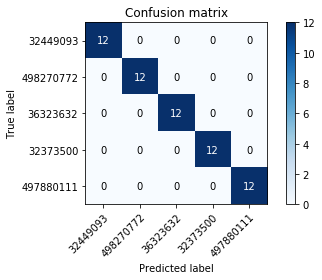

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.

    """
    
    title = title

    # Compute confusion matrix
    cm = confusion_matrix(y_truth, y_pred)
    # Only use the labels that appear in the data

    print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #Loop over data dimensions and create text annotations.

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_truth, y_pred, classes=class_names,
                      title='Confusion matrix')

plt.show()